In [1]:
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 12

In [2]:
test_df = pd.read_csv('input/test_df.csv', index_col='img')
test_df

,1,2,3,4,defects
img,,,,,
008ef3d74.jpg,356336 4 356587 11 356838 18 357089 25 357340 ...,375439 5 375687 14 375935 24 376182 34 376430 ...,NaN,NaN,2
c98404d89.jpg,NaN,113365 14 113595 40 113824 67 114053 94 114283...,NaN,NaN,1
cdc267505.jpg,NaN,108278 11 108513 32 108749 52 108984 73 109219...,NaN,NaN,1
2012a6d02.jpg,NaN,217692 17 217948 51 218204 85 218459 103 21871...,NaN,NaN,1
00c88fed0.jpg,10474 7 10728 15 10983 18 11239 21 11494 24 11...,13428 8 13684 24 13940 39 14196 55 14452 71 14...,NaN,NaN,2
...,...,...,...,...,...
2279bbcc4.jpg,NaN,NaN,NaN,NaN,0
394c73130.jpg,NaN,NaN,NaN,NaN,0
3505b6c74.jpg,NaN,NaN,NaN,NaN,0


In [3]:
def load_df(path):
    df = pd.read_csv(path)
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
    df = df.reindex(columns=[1, 2, 3, 4])
    df['defects'] = df.count(axis=1)
    df = df.rename({'ImageId': 'img'}, axis='columns')
    return df

In [5]:
unet18 = load_df('output/predictions/Unet(ResNet18).csv')
unet34 = load_df('output/predictions/Unet(ResNet34).csv')
unet50 = load_df('output/predictions/Unet(ResNet50).csv')
enet = load_df('output/predictions/ENet.csv')

In [6]:
def get_mask(df, image_id):
    labels = df.loc[image_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)
    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(' ')
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return masks

def show_mask(masks, path, image_id):
    palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249, 50, 12)]
    img = cv2.imread(os.path.join(path, image_id))
    fig, ax = plt.subplots(figsize=(15, 15))
    title = image_id + ' '
    for ch in range(4):
        contours, _ = cv2.findContours(masks[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
            title += str(ch + 1)
    ax.set_title(title)
    ax.imshow(img)
    plt.show()

In [7]:
def metrics(pred, truth):
    pred = np.transpose(pred, (2, 0, 1))  # 4x256x1600
    pred = pred.reshape(4,-1)
    truth = np.transpose(truth, (2, 0, 1))  # 4x256x1600
    truth = truth.reshape(4,-1)
    assert (pred.shape == truth.shape)

    p = (pred > 0.5)
    t = (truth > 0.5)
    
    neg_index = np.nonzero(t.sum(-1) == 0)[0]
    pos_index = np.nonzero(t.sum(-1) >= 1)[0]

    neg = (p.astype(float).sum(-1) == 0).astype(float)
    dice_pos = 2 * (p & t).sum(-1) / ((p.astype(float) + t.astype(float)).sum(-1))
    iou_pos = (p & t).sum(-1).astype(float) / ((p | t).sum(-1))

    dice = np.zeros(4)
    dice[neg_index] = neg[neg_index]
    dice[pos_index] = dice_pos[pos_index]
    
    iou = np.zeros(4)
    iou[neg_index] = neg[neg_index]
    iou[pos_index] = iou_pos[pos_index]
    
    classes = []
    for i in range(4):
        if dice[i] > 0.2:
            if i in neg_index:
                classes.append('TN')
            else:
                classes.append('TP')
        else:
            if i in neg_index:
                classes.append('FP')
            else:
                classes.append('FN')    
    return dice, iou, classes

In [8]:
def show_compare(img, test, pred):
    test_mask = get_mask(test, img)
    show_mask(test_mask, 'input/train_images', img)
    if img in pred.index:
        pred_mask = get_mask(pred, img)
        show_mask(pred_mask, 'input/train_images', img)
        dice, iou, classes = metrics(pred_mask, test_mask)        
    else:
        classes = ['TN', 'TN', 'TN', 'TN']
        dice = test.loc[img][:4].notna().to_numpy().astype(float)
        iou = dice
    print('dice: {}\n IoU: {}\n classes: {}'.format(dice, iou, classes))        

In [9]:
def compare(test, pred):
    metr = []
    dices = []
    for img in test.index:
        test_mask = get_mask(test, img)
        if img in pred.index:
            pred_mask = get_mask(pred, img)
            dice, iou, classes = metrics(pred_mask, test_mask)        
        else:
            classes = ['TN', 'TN', 'TN', 'TN']
            dice = test.loc[img][:4].notna().to_numpy().astype(float)
        metr.append(classes)
        dices.append(dice)
    metr = np.array(metr)
    dices = np.array(dices)
    return pd.DataFrame(data=metr, index=test.index, columns=[1, 2, 3, 4]), pd.DataFrame(data=dices, index=test.index, columns=[1, 2, 3, 4])

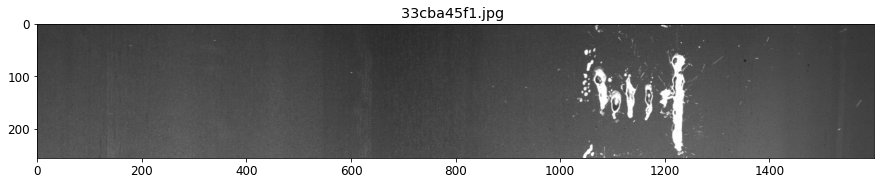

dice: [0. 0. 0. 0.]
 IoU: [0. 0. 0. 0.]
 classes: ['TN', 'TN', 'TN', 'TN']


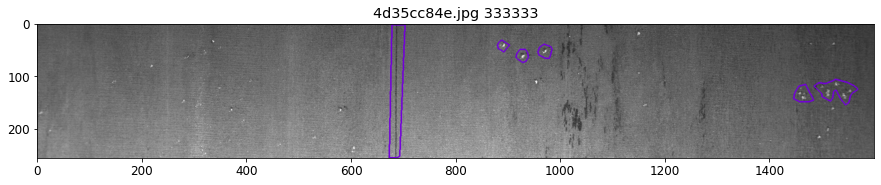

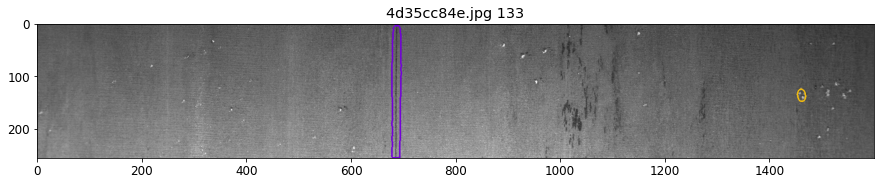

dice: [0.         1.         0.57318657 1.        ]
 IoU: [0.         1.         0.40172496 1.        ]
 classes: ['FP', 'TN', 'TP', 'TN']


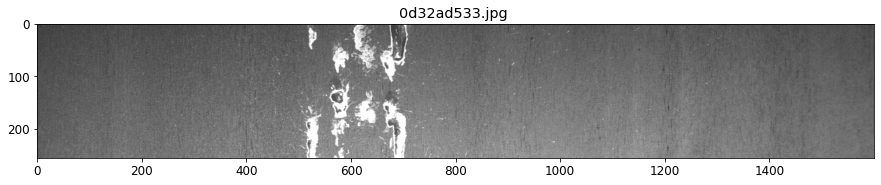

dice: [0. 0. 0. 0.]
 IoU: [0. 0. 0. 0.]
 classes: ['TN', 'TN', 'TN', 'TN']


In [27]:
imgs = np.random.choice(test_df.index, 3, replace=False)
for img in imgs:
    show_compare(img, test_df, unet50)

In [10]:
warnings.filterwarnings('ignore')
classes18, dices18 = compare(test_df, unet18)

In [11]:
warnings.filterwarnings('ignore')
classes34, dices34 = compare(test_df, unet34)

In [12]:
warnings.filterwarnings('ignore')
classes50, dices50 = compare(test_df, unet50)

In [13]:
warnings.filterwarnings('ignore')
classesenet, dicesenet = compare(test_df, enet)

In [21]:
def class_metrics(df):
    metr = []
    for i in range(1, 5):
        vc = df[i].value_counts()
        TP = vc['TP'] if 'TP' in vc.keys() else 0
        TN = vc['TN'] if 'TN' in vc.keys() else 0
        FP = vc['FP'] if 'FP' in vc.keys() else 0
        FN = vc['FN'] if 'FN' in vc.keys() else 0    
        metr.append({'accuracy' : (TP + TN) / (TP + TN + FP + FN),
         'precision' : TP / (TP + FP),
         'recall': TP / (TP + FN)})
        print('class {} metr: {}'.format(i, metr[i-1]))
    return metr

In [22]:
metr18 = class_metrics(classes18)
metr34 = class_metrics(classes34)
metr50 = class_metrics(classes50)
metrenet = class_metrics(classesenet)

class 1 metr: {'accuracy': 0.8982107355864811, 'precision': 0.36363636363636365, 'recall': 0.7607361963190185}
class 2 metr: {'accuracy': 0.88389662027833, 'precision': 0.12538226299694188, 'recall': 0.8723404255319149}
class 3 metr: {'accuracy': 0.8532803180914513, 'precision': 0.8061440677966102, 'recall': 0.8035902851108765}
class 4 metr: {'accuracy': 0.9502982107355865, 'precision': 0.5637065637065637, 'recall': 0.9240506329113924}
class 1 metr: {'accuracy': 0.6091451292246521, 'precision': 0.14145907473309607, 'recall': 0.8983050847457628}
class 2 metr: {'accuracy': 0.8608349900596421, 'precision': 0.12311557788944724, 'recall': 0.98}
class 3 metr: {'accuracy': 0.8135188866799204, 'precision': 0.7927927927927928, 'recall': 0.7118301314459049}
class 4 metr: {'accuracy': 0.9447316103379721, 'precision': 0.5387596899224806, 'recall': 0.8742138364779874}
class 1 metr: {'accuracy': 0.7137176938369781, 'precision': 0.18706697459584296, 'recall': 0.9101123595505618}
class 2 metr: {'accur

In [23]:
dices18.describe()

,1,2,3,4
count,2515.000000,2515.000000,2515.000000,2515.000000
mean,0.441340,0.436849,0.341875,0.491146
std,0.484729,0.492482,0.401866,0.488858
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.488525
75%,1.000000,1.000000,0.747098,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [24]:
dices34.describe()

,1,2,3,4
count,2515.000000,2515.000000,2515.000000,2515.000000
mean,0.239172,0.504761,0.378534,0.579584
std,0.409720,0.495859,0.418286,0.482744
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.666257,0.118767,1.000000
75%,0.512450,1.000000,0.810881,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [25]:
dices50.describe()

,1,2,3,4
count,2515.000000,2515.000000,2515.000000,2515.000000
mean,0.343132,0.525089,0.413307,0.583157
std,0.459519,0.495410,0.425196,0.482030
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.276828,1.000000
75%,1.000000,1.000000,0.858087,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [26]:
dicesenet.describe()

,1,2,3,4
count,2515.000000,2515.000000,2515.000000,2515.000000
mean,0.421583,0.557185,0.394977,0.536744
std,0.481315,0.492409,0.424299,0.486867
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.153676,0.889798
75%,1.000000,1.000000,0.842222,1.000000
max,1.000000,1.000000,1.000000,1.000000
